<a href="https://colab.research.google.com/github/babelfishz/colab-models/blob/master/modeller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls '/content/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
 calendar	    dataset   ppbc	 test
'Colab Notebooks'   _models   progress	 我的足迹


In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
import itertools
from tensorflow.keras.layers import GlobalAveragePooling2D

%matplotlib inline
#%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
def train_vgg16_model(dataset, save_path):
  train_path = dataset + 'train'
  valid_path = dataset + 'val'
  #test_path = dataset+ 'test'

  #trying to add some augumentation
  train_batches = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    #horizontal_flip=True
  ).flow_from_directory(train_path,target_size=(224,224),  batch_size=32)

  # the validation data should not be augmented!
  valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(valid_path,target_size=(224,224),  batch_size=32)

  #test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),  batch_size=32)

  print(valid_batches.class_indices.keys())

  vgg16_model = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
  for layer in vgg16_model.layers[:-4]:
    layer.trainable = False
    
  # Create the model
  model = Sequential()
 
  # Add the vgg convolutional base model
  model.add(vgg16_model)
 
  # Add new layers
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(80, activation='softmax'))
 
  # Show a summary of the model. Check the number of trainable parameters
  model.summary()

  model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

  history = model.fit(train_batches, 
            epochs=10, 
            validation_data=valid_batches, 
            steps_per_epoch=train_batches.samples/train_batches.batch_size,
            validation_steps=valid_batches.samples/valid_batches.batch_size,
            verbose=1)

  tf.keras.models.save_model(model, save_path)
  print("models written to ", save_path)

  #test_imgs, test_labels = next(test_batches)
  #predictions = model.predict(test_imgs)
  #print(predictions)

In [0]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_generator)
plots(imgs, titles=labels)

In [0]:
# plots train history with labels within jupyter notebook
import matplotlib.pyplot as plt

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
#preprocess base64 image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_b64_image(image_bytes, height, width):
    image = tf.io.decode_base64(image_bytes[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size=[height, width])
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    #image = (image - 127.5) / 127.5
    image = tf.expand_dims(image, axis=0)
    return image

In [0]:
#load dataset for train
from tensorflow.keras.applications.inception_v3 import preprocess_input

dataset = '/content/gdrive/My Drive/dataset/'

train_dir = dataset + 'train'
validation_dir = dataset + 'val'
test_dir = dataset+ 'test'


target_size =(299 , 299)
#classes = ['广东石豆兰','橙黄玉凤花','建兰']

train_datagen = ImageDataGenerator(
                    preprocessing_function = preprocess_input
#                    rescale = 1./255.,
#                    rotation_range = 40,
#                    width_shift_range = 0.2,
#                    height_shift_range = 0.2,
#                    shear_range = 0.2,
#                    zoom_range = 0.2,
#                    horizontal_flip = True
                  )
test_datagen = ImageDataGenerator( 
#                    rescale = 1.0/255. 
                    preprocessing_function = preprocess_input
                  )  

train_generator = train_datagen.flow_from_directory(train_dir, target_size = target_size)
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size = target_size)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=target_size) 
nclass = len(train_generator.class_indices)

print(validation_generator.class_indices.keys())

Found 3525 images belonging to 80 classes.
Found 1462 images belonging to 80 classes.
Found 12 images belonging to 80 classes.
dict_keys(['三蕊兰', '三褶虾脊兰', '二列叶虾脊兰', '二尾兰', '二色卷瓣兰', '云南叉柱兰', '低地羊耳蒜', '全唇盂兰', '北插天天麻', '半柱毛兰', '南方带唇兰', '叉柱兰', '地宝兰', '坡参', '墨兰', '多叶斑叶兰', '多枝拟兰', '多花脆兰', '大序隔距兰', '寄树兰', '密花石豆兰', '寒兰', '小片菱兰', '小舌唇兰', '尖喙隔距兰', '广东石豆兰', '广东隔距兰', '建兰', '扇唇羊耳蒜', '报春贝母兰', '插天山羊耳蒜', '撕唇阔蕊兰', '斑唇卷瓣兰', '无叶美冠兰', '橙黄玉凤花', '歌绿斑叶兰', '永泰卷瓣兰', '流苏贝母兰', '深裂沼兰', '牛齿兰', '玫瑰宿苞兰', '瘤唇卷瓣兰', '白绵绒兰', '白花线柱兰', '短穗竹茎兰', '短裂阔蕊兰', '石仙桃', '竹叶兰', '竹茎兰', '紫纹兜兰', '紫花羊耳蒜', '线柱兰', '细叶石仙桃', '细裂玉凤花', '绶草', '绿花带唇兰', '绿花斑叶兰', '美冠兰', '腐生齿唇兰', '芳香石豆兰', '苞舌兰', '蛇舌兰', '蛤兰', '血叶兰', '见血青', '触须阔蕊兰', '金线兰', '钳唇兰', '镰翅羊耳蒜', '长茎羊耳蒜', '阔叶沼兰', '香港带唇兰', '香港绶草', '高斑叶兰', '鹅毛玉凤花', '鹤顶兰', '黄兰', '黄唇线柱兰', '齿瓣石豆兰', '龙头兰'])


Epoch 1/10
111/110 [==============================] - 2041s 18s/step - loss: 3.9873 - acc: 0.1155 - val_loss: 3.3752 - val_acc: 0.2804
Epoch 2/10
111/110 [==============================] - 1113s 10s/step - loss: 3.1361 - acc: 0.2982 - val_loss: 2.6854 - val_acc: 0.4781
Epoch 3/10
111/110 [==============================] - 1115s 10s/step - loss: 2.5182 - acc: 0.4357 - val_loss: 2.2060 - val_acc: 0.5643
Epoch 4/10
111/110 [==============================] - 1114s 10s/step - loss: 2.1071 - acc: 0.5183 - val_loss: 1.8732 - val_acc: 0.6211
Epoch 5/10
111/110 [==============================] - 1127s 10s/step - loss: 1.7619 - acc: 0.5949 - val_loss: 1.6245 - val_acc: 0.6648
Epoch 6/10
111/110 [==============================] - 1120s 10s/step - loss: 1.5027 - acc: 0.6502 - val_loss: 1.4395 - val_acc: 0.7025
Epoch 7/10
111/110 [==============================] - 1119s 10s/step - loss: 1.2997 - acc: 0.7044 - val_loss: 1.2961 - val_acc: 0.7182
Epoch 8/10
111/110 [==============================] - 1

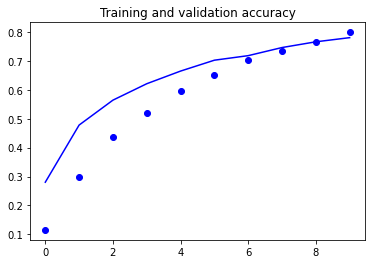

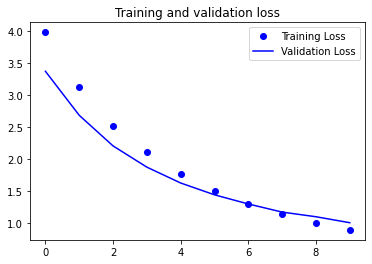

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/_models/flower/1/assets
models written to  /content/gdrive/My Drive/_models/flower/1


In [0]:
#training a model and save it
from tensorflow.keras.optimizers import RMSprop

# 构建不带分类器的预训练模型
base_model = InceptionV3(weights='imagenet', include_top=False)
for layer in base_model.layers:
  layer.trainable = False
  
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  
predictions = Dense(nclass, activation='softmax')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
  
# Show a summary of the model. Check the number of trainable parameters
#model.summary()

history = model.fit(train_generator, 
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs=10, 
            validation_data=validation_generator, 
            validation_steps=validation_generator.samples/validation_generator.batch_size,
            verbose=1)

#tf.keras.models.save_model(model, save_path)
#print("models written to ", save_path)

plot_history(history)


save_path = '/content/gdrive/My Drive/_models/flower/1'
tf.keras.models.save_model(model, save_path)
print("models written to ", save_path)

In [0]:
  test_imgs, test_labels = next(test_generator)
  plots(test_imgs, titles=test_labels)

  predictions = model.predict(test_imgs)
  print(predictions)

In [0]:
save_path = '/content/gdrive/My Drive/_models/flower/1'

saved_model = tf.keras.models.load_model(save_path)
#input_shape = (None, 299, 299, 3)
#saved_model.build(input_shape)
saved_model.summary()

image_bytes = tf.keras.Input(shape=[], batch_size=1, name='b64_image_bytes', dtype=tf.string)
preprocessed_image = preprocess_b64_image(image_bytes, 299, 299)
predictions = saved_model(preprocessed_image)
  
new_model = tf.keras.Model(image_bytes, predictions)
new_model.summary()
  
tf.keras.models.save_model(new_model, "./gdrive/My Drive/_models/flower/2")

Check saved models' info

In [0]:
!ls '/content/gdrive/My Drive/dataset/test'

In [0]:
!saved_model_cli show --dir ./gdrive/My\ Drive/_models/flower/2 --all

client test code for TF servering  

In [0]:
!wget -q -O "1.jpg" "https://www.ocalendar.com.cn//storage/uploads/images/1561213187_Ik3R95v6OL.jpg"
!wget -q -O "2.jpg" "https://www.ocalendar.com.cn//storage/uploads/images/1567077582_sQ9kqOtQUc.jpg"
!wget -q -O "3.jpg" "https://www.ocalendar.com.cn//storage/uploads/images/1563020145_RGu8AStYOc.jpg"

In [8]:
!ls

1.jpg  2.jpg  3.jpg  gdrive  sample_data


In [0]:
import requests
import base64
import json
import tensorflow as tf

url = "http://8.210.62.249:8501/v1/models/flower:predict"

with open('1.jpg', "rb") as img_file:
  encoded_string = base64.urlsafe_b64encode(img_file.read()).decode("utf-8")
data = json.dumps({"instances": [{"b64_image_bytes": encoded_string}]})

print(data)

r = requests.post(url = url, data = data)
r.json()
